In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
df = pd.read_csv('//content/IMDB Dataset.csv', engine='python', on_bad_lines='skip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.shape


(50000, 2)

In [ ]:
df.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
df.dropna()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
def clean_text(text):
    try:
        # menghapus tag HTML
        text = re.sub(r'<.*?>', '', str(text))
        # menghapus karakter khusus
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = text.lower()
        # untuk menghapus spasi berlebih
        text = ' '.join(text.split())
        return text
    except:
        return ""
df['clean_review'] = df['review'].apply(clean_text)
df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


menghapus ulasan yang kosong setelah proses pembersihan

In [ ]:
df = df[df['clean_review'].str.len() >10 ]
len(df)

print(f"\ncontoh teks setelah pembersihan:\n{df['clean_review'].iloc[0][:200]}...")


contoh teks setelah pembersihan:
one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brut...


Encoding Label

In [ ]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
if df['label'].isna().any():
  df=df.dropna(subset=['label'])

df[['sentiment', 'label']].head()
len(df)

50000

Bert Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 8

class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Split Data

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Jumlah sampel pelatihan: {len(train_df)}")
print(f"Jumlah sampel validasi: {len(val_df)}")
print(f"Jumlah sampel pengujian: {len(test_df)}")

Jumlah sampel pelatihan: 35000
Jumlah sampel validasi: 7500
Jumlah sampel pengujian: 7500


Membuat Dataset

In [ ]:
train_dataset = IMDBDataset(
    reviews=train_df['clean_review'].to_numpy(),
    labels=train_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = IMDBDataset(
    reviews=val_df['clean_review'].to_numpy(),
    labels=val_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = IMDBDataset(
    reviews=test_df['clean_review'].to_numpy(),
    labels=test_df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)



Membuat Dataloader

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=2
)

Bert untuk sequence classification

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Data

In [ ]:
EPOCHS = 2
LEARNING_RATE = 2e-5
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  eps=1e-8)
total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

print(f"total_steps: {total_steps}")

total_steps: 8750


Fungsi untuk menghitung akurasi

In [ ]:
def calculate_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

Training

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

try:
    for epoch in range(EPOCHS):
        print(f'\n{"="*60}')
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print("="*60)

        model.train()
        total_train_loss = 0
        train_preds = []
        train_labels_list = []

        progress_bar = tqdm(train_dataloader, desc='Training')
        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            model.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            #pengumpulan prediksi
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            train_preds.extend(logits)
            train_labels_list.extend(label_ids)

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
            if batch_idx % 50 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_acc = calculate_accuracy(np.array(train_preds), np.array(train_labels_list))

        print(f'\nHasil Training:')
        print(f'   Loss: {avg_train_loss:.4f} | Akurasi: {train_acc:.4f}')

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_preds = []
        val_labels_list = []

        with torch.no_grad():
            progress_bar = tqdm(val_dataloader, desc='Validation')
            for batch in progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_val_loss += loss.item()

                # mengumpulkan prediksi
                logits = outputs.logits.detach().cpu().numpy()
                label_ids = labels.to('cpu').numpy()
                val_preds.extend(logits)
                val_labels_list.extend(label_ids)

                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_acc = calculate_accuracy(np.array(val_preds), np.array(val_labels_list))
        val_accuracies.append(val_acc)

        print(f'Hasil Validasi:')
        print(f'   Loss: {avg_val_loss:.4f} | Akurasi: {val_acc:.4f}')

except Exception as e:
    print(f"An error occurred during training: {e}")


Epoch 1/2


Training: 100%|██████████| 4375/4375 [15:17<00:00,  4.77it/s, loss=0.2743]



Hasil Training:
   Loss: 0.3520 | Akurasi: 0.8639


Validation: 100%|██████████| 938/938 [00:56<00:00, 16.48it/s, loss=0.0361]


Hasil Validasi:
   Loss: 0.2916 | Akurasi: 0.8877

Epoch 2/2


Training: 100%|██████████| 4375/4375 [15:19<00:00,  4.76it/s, loss=1.6083]



Hasil Training:
   Loss: 0.2210 | Akurasi: 0.9385


Validation: 100%|██████████| 938/938 [00:57<00:00, 16.40it/s, loss=0.0020]

Hasil Validasi:
   Loss: 0.4242 | Akurasi: 0.8991


Evaluasi Model

In [ ]:
model.eval()
test_preds = []
test_labels_list = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        test_preds.extend(logits)
        test_labels_list.extend(label_ids)

Testing: 100%|██████████| 938/938 [00:55<00:00, 16.84it/s]



 Test Akurasi: 0.8957

 Hasil vClassification :
              precision    recall  f1-score   support

    negative       0.90      0.89      0.89      3722
    positive       0.89      0.90      0.90      3778

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500



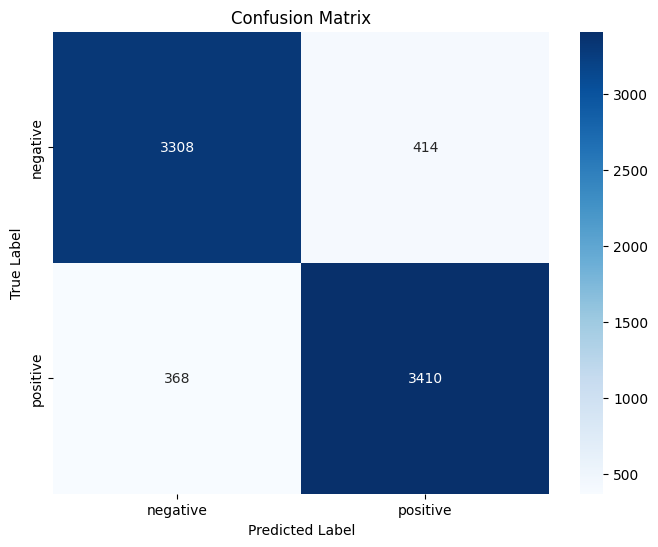

In [ ]:
test_preds_flat = np.argmax(test_preds, axis=1).flatten()
test_labels_flat = np.array(test_labels_list).flatten()

    # Metrik evaluasi
test_accuracy = accuracy_score(test_labels_flat, test_preds_flat)
print(f"\n Test Akurasi: {test_accuracy:.4f}")
print("\n Hasil vClassification :")
print(classification_report(test_labels_flat, test_preds_flat,
                               target_names=['negative', 'positive']))

    # Confusion matrix
cm = confusion_matrix(test_labels_flat, test_preds_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'positive'],
                yticklabels=['negative', 'positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Visualisasi hasil training

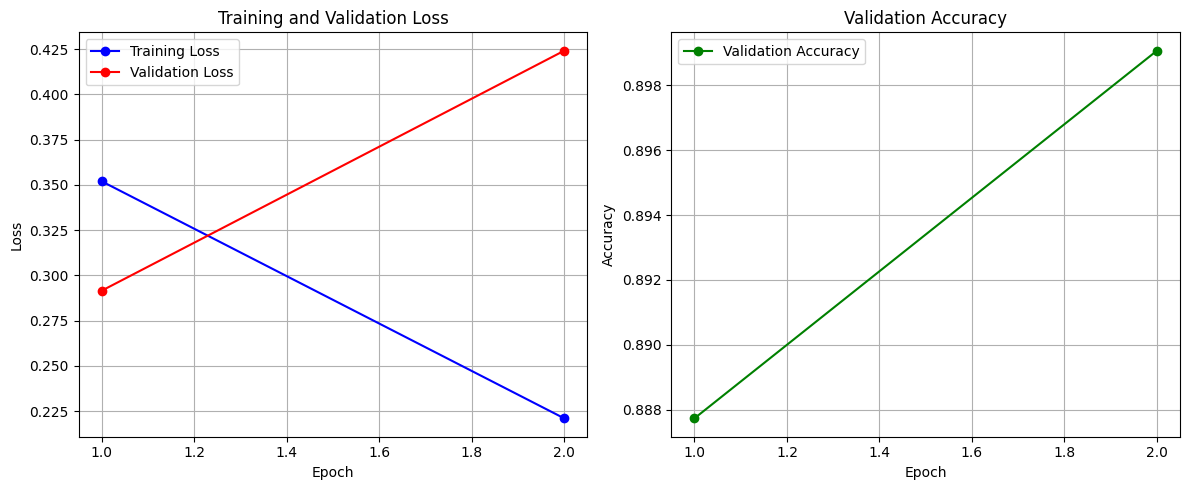

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, 'b-o', label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, 'r-o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), val_accuracies, 'g-o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def predict_sentiment(text, model, tokenizer, device):
        # membersihkan teks
        text = clean_text(text)

        # tokenisasi
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # prediksi
        model.eval()
        with torch.no_grad():
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            prediction = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][prediction].item()

        sentiment = 'positive' if prediction == 1 else 'negative'

        return {
            'text': text,
            'sentiment': sentiment,
            'confidence': confidence,
            'probabilities': {
                'negative': probabilities[0][0].item(),
                'positive': probabilities[0][1].item()
            }
        }

#contoh teks prediksi
sample_texts = [
    "This movie was absolutely fantastic! I loved every minute of it.",
    "Terrible film, waste of time and money. I regret watching it.",
    "The acting was good but the plot was confusing and boring.",
    "One of the best movies I've seen this year, highly recommended!"
]

for i, text in enumerate(sample_texts):
    result = predict_sentiment(text, model, tokenizer, device)
    print(f"\nContoh {i+1}:")
    print(f"Teks: {text[:50]}...")
    print(f"Sentimen: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Prob - Negatif: {result['probabilities']['negative']:.2%}, Positif: {result['probabilities']['positive']:.2%}")


Contoh 1:
Teks: This movie was absolutely fantastic! I loved every...
Sentimen: positive
Confidence: 99.92%
Prob - Negatif: 0.08%, Positif: 99.92%

Contoh 2:
Teks: Terrible film, waste of time and money. I regret w...
Sentimen: negative
Confidence: 99.93%
Prob - Negatif: 99.93%, Positif: 0.07%

Contoh 3:
Teks: The acting was good but the plot was confusing and...
Sentimen: negative
Confidence: 99.81%
Prob - Negatif: 99.81%, Positif: 0.19%

Contoh 4:
Teks: One of the best movies I've seen this year, highly...
Sentimen: positive
Confidence: 99.93%
Prob - Negatif: 0.07%, Positif: 99.93%


penyimpanan model

In [ ]:
model_save_path = './bert_sentiment_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"model tersimpan: {model_save_path}")

model tersimpan: ./bert_sentiment_model
